In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

path = 'return-data/'
filelist = os.listdir(path) 
dfs = [pd.read_json(path+file, lines=True) for file in filelist]
toydata = pd.concat(dfs, ignore_index=True)

In [2]:
toydata = toydata.merge(toydata['basket'].apply(lambda x: pd.Series({'c_0': x.count(0), 'c_1': x.count(1),'c_2': x.count(2),'c_3': x.count(3),'c_4': x.count(4),'c_5': x.count(5)})), left_index=True, right_index=True)
toydata.drop(['basket','transactionId','zipCode'],axis=1,inplace=True)
toydata.head()

,returnLabel,totalAmount,c_0,c_1,c_2,c_3,c_4,c_5
0,0,264,1,3,3,0,0,1
1,1,60,0,1,1,1,3,0
2,0,60,0,0,0,0,0,1
3,0,333,1,0,0,1,1,0
4,0,378,2,1,2,1,0,0


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(toydata.drop('returnLabel',axis=1),toydata['returnLabel'], test_size=0.30,random_state=101)

In [4]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

def cross_validation(clf, X_train, y_train, k=3):
    cv_score_values = []

    X_train = np.array_split(X_train, k)
    y_train = np.array_split(y_train, k)

    for i in range(k):
        X_validation_data = X_train[i]
        y_validation_data = y_train[i]

        arrayWithoutCurrentPosition = createArrayWithoutSubArray(X_train, i)

        X_cur_train = createArrayWithoutSubArray(X_train, i)
        y_cur_train = createArrayWithoutSubArray(y_train, i)
        
        clf.fit(X_cur_train,y_cur_train)
        validation_pred_proba = clf.predict_proba(X_validation_data)[::,1]
        validation_roc_auc = roc_auc_score(y_validation_data, validation_pred_proba)
        
        cv_score_values.append(validation_roc_auc)
    
    cv_score = np.average(cv_score_values)
    
    return cv_score

def createArrayWithoutSubArray(arrayList, indexToRemove):
    joinedList = arrayList[:indexToRemove] + arrayList[indexToRemove+1:]

    arrayWithoutSubArray = pd.concat(joinedList, ignore_index=True)        
    return arrayWithoutSubArray

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

random_clf_default = RandomForestClassifier()
random_clf1 = RandomForestClassifier(n_estimators=10, max_depth=10)
random_clf2 = RandomForestClassifier(n_estimators=100, max_depth=10)
random_clf3 = RandomForestClassifier(n_estimators=200, max_depth=10)
random_clf4 = RandomForestClassifier(n_estimators=100, max_depth=20)
random_clf5 = RandomForestClassifier(n_estimators=100, max_depth=30)

print(cross_validation(random_clf1, X_train, y_train, 4))
print(cross_validation(random_clf2, X_train, y_train, 4))
print(cross_validation(random_clf3, X_train, y_train, 4))
print(cross_validation(random_clf4, X_train, y_train, 4))
print(cross_validation(random_clf5, X_train, y_train, 4))

0.927341082713903
0.9306578300334164
0.931694402582582
0.8689804090014102
0.8499266884796454


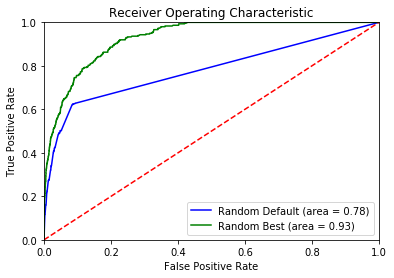

In [10]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

# default random forst roc
random_clf_default.fit(X_train,y_train)
y_pred_proba_rnd_default = random_clf_default.predict_proba(X_test)[::,1]
fpr_rnd_default, tpr_rnd_default, threshold_rnd_default = metrics.roc_curve(y_test, y_pred_proba_rnd_default)
roc_auc_rnd_default = roc_auc_score(y_test, y_pred_proba_rnd_default)

# best CV random forest roc
random_clf3.fit(X_train,y_train)
y_pred_proba_rnd_best = random_clf3.predict_proba(X_test)[::,1]
fpr_rnd_best, tpr_rnd_best, threshold_rnd_best = metrics.roc_curve(y_test, y_pred_proba_rnd_best)
roc_auc_rnd_best = roc_auc_score(y_test, y_pred_proba_rnd_best)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rnd_default, tpr_rnd_default, 'b', label = 'Random Default (area = %0.2f)' % roc_auc_rnd_default)
plt.plot(fpr_rnd_best, tpr_rnd_best, 'g', label = 'Random Best (area = %0.2f)' % roc_auc_rnd_best)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()